## Homework №1

### Part 1. Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
! wget http://www.gutenberg.org/cache/epub/1041/pg1041.txt 

--2019-07-16 14:21:38--  http://www.gutenberg.org/cache/epub/1041/pg1041.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122780 (120K) [text/plain]
Saving to: ‘pg1041.txt’

pg1041.txt          100%[===================>] 119.90K   559KB/s    in 0.2s    

2019-07-16 14:21:38 (559 KB/s) - ‘pg1041.txt’ saved [122780/122780]



In [3]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))
text = [preprocess(x) for x in text ]
text = ' '.join(text)
len(text)
# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

97989

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here

idx_to_token = {idx: token for token, idx in token_to_idx.items()}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [8]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(text), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat((x_emb, h_prev), dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
    
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [18]:
char_rnn = CharRNNCell()

In [19]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [21]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

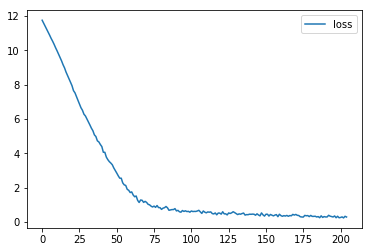

KeyboardInterrupt: 

In [22]:
from IPython.display import clear_output
from random import sample

opt = torch.optim.Adam(char_rnn.parameters())
history = []

MAX_LENGTH = 16

for i in range(500):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>
    
    history.append(loss.data.numpy())
    if (i+1)%5==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [15]:
# An example of generated text. There is no function `generate_text` in the code above.
num_tokens = len(text)

def generate_text(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
  
  
print(generate_text(char_rnn, max_length=500, temperature=0.2))

/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [0]:
device = 'cuda:0'

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(text), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return Variable(torch.zeros(batch_size, self.num_units)), Variable(torch.zeros(batch_size, self.num_units))
    
char_lstm = CharLSTMCell().to(device)



In [17]:
MAX_LENGTH = 16

for i in range(500):
    print(i)
    
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = Variable(torch.LongTensor(batch_ix)).to(device)

    logp_seq = rnn_loop(char_lstm, batch_ix)

    # compute loss. This time we use nll_loss with some duct tape
    loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, len(text)), batch_ix[:, :-1].contiguous().view(-1))

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

        

0


RuntimeError: ignored

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [0]:
# Text generation with different temperature values here
for i in  [0.1, 0.2, 0.5, 1.0, 2.0]: 
    print(generate_text(char_lstm, length=500, temperature=i))

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
# Saving and loading code here
torch.save(model, r"C:\Program Files\iTunes\hw.pt")

In [0]:
model = torch.load(r"C:\Program Files\iTunes\hw.pt")
model.eval()

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)